## Exponential Smoothing in Python

This notebook illustrates how to do exponential smoothing in python using modules in [statsmodels](https://www.statsmodels.org/stable/index.html). The notebook is based on the [tutorial](https://github.com/statsmodels/statsmodels/blob/de9a7da489e642847e7b025951cc4bb6d081564b/examples/notebooks/exponential_smoothing.ipynb) from statsmodels, with data from [NIST's handbook on time series analysis](https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc4.htm).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

import scipy.stats as st

import statsmodels.api as sm

## Single exponential smoothing

Data from [NIST](https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc431.htm)

In [9]:
data = pd.read_csv('data/SingleExp.dat', sep = '\s+', index_col = 0)

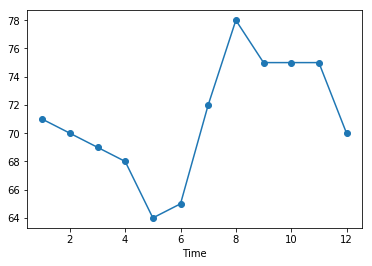

In [10]:
data['yt'].plot(marker = 'o')

Check the usage of [SimpleExpSmoothing](https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.SimpleExpSmoothing.html)

Test different $\alpha$:

1. $\alpha=0.1$
2. $\alpha=0.5$
3. allow statsmodels to automatically find an optimized $\alpha$ value for us.

In [11]:
fit1 = SimpleExpSmoothing(data['yt'].values).fit(smoothing_level = 0.1, optimized = False)
fcast1 = fit1.forecast(3)

fit2 = SimpleExpSmoothing(data['yt'].values).fit(smoothing_level = 0.5, optimized = False)
fcast2 = fit2.forecast(3)

fit3 = SimpleExpSmoothing(data['yt'].values).fit()
fcast3 = fit3.forecast(3)

Put them together and compare

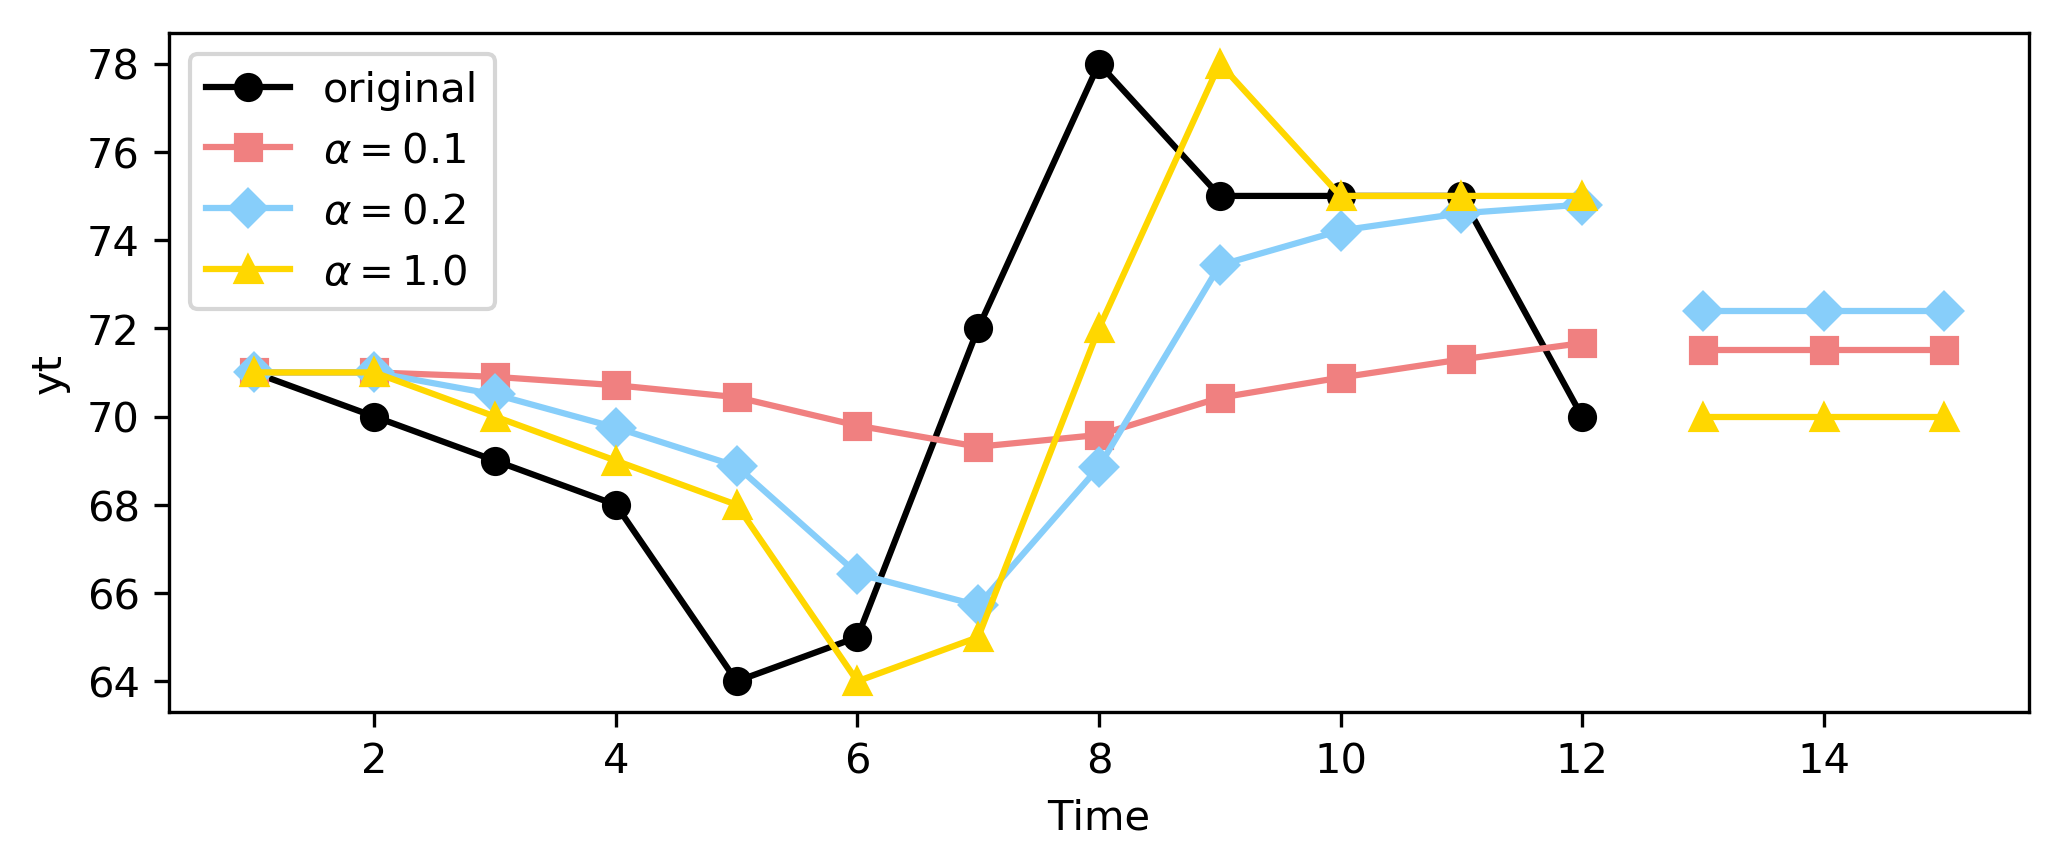

In [12]:
fig = plt.figure(figsize = (8, 3), dpi = 300)
data['yt'].plot(marker = 'o', color = 'k', label = 'original')
plt.plot(data.index, fit1.fittedvalues, 's-', color='lightcoral', label=r'$\alpha=0.1$')
plt.plot(range(data.index.max()+1, data.index.max()+4), fcast1, 's-', color='lightcoral')
plt.plot(data.index, fit2.fittedvalues, 'D-', color='lightskyblue', label=r'$\alpha=0.2$')
plt.plot(range(data.index.max()+1, data.index.max()+4), fcast2, 'D-', color='lightskyblue')
plt.plot(data.index, fit3.fittedvalues, '^-', color='gold', 
         label=r'$\alpha=%.1f$' %fit3.params['smoothing_level'])
plt.plot(range(data.index.max()+1, data.index.max()+4), fcast3, '^-', color='gold')
plt.ylabel('yt')
plt.legend(loc = 'upper left');

We can see from the plot above that Single Exponential Smoothing results in a straight, flat-line forcast that is best for volatile data with no trend or seasonality.

Using bootstrapping for forecasts could have a curvy line, but it seems not to be implememted in statsmodels.

R could also provide Prediction intervals, but not available in python. Accoring to [this post](https://stats.stackexchange.com/questions/172752/how-can-i-calculate-the-pi-of-simple-exponential-smoothing), the h-step forecast variance is given by

$v_{T+h|T}=\sigma^2(1+\alpha^2(h-1))$

The the 95% confidence interval is

$\hat{y}_{T+h}\pm1.96\sqrt{v_{T+h|T}}$

In [71]:
def confintervals(model, steps, pct = 0.95):
    z = st.norm.ppf(1-(1-pct)/2)
    print('Point\tForecast\tLo 95\t\tHi 95')
    for i in range(steps):
        var = model.sse/(len(model.fittedvalues)-1)*(1+model.params['smoothing_level']**2*i)
        print('%d\t%f\t%f\t%f' %(len(model.fittedvalues)+i+1, model.fcastvalues[0], model.fcastvalues[0]-z*np.sqrt(var), 
              model.fcastvalues[0]+z*np.sqrt(var)))

In [72]:
confintervals(fit1, 3)

Point	Forecast	Lo 95		Hi 95
13	71.498754	62.959182	80.038327
14	71.498754	62.916590	80.080919
15	71.498754	62.874209	80.123300


## Double exponential smoothing (Holt's Method)

Data from [NIST](https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc434.htm)

In [73]:
dt = np.loadtxt('data/DoubExp.dat')

Test different $\alpha$ and $\beta$:

1. Holt's additive model, with $\alpha=0.3623,\beta=1$
2. Holt's multiplicative model, with $\alpha=0.3623,\beta=1$
3. Holt's additive model, but allow dampening parameter $\phi$ to be optimized, with $\alpha=0.3623,\beta=1$
4. Holt's additive model, allowing damping, with all parameters optimized
5. Single exponential model

In [102]:
fit1 = Holt(dt).fit(smoothing_level=0.3623, smoothing_slope=1,optimized=False)
fit2 = Holt(dt, exponential=True).fit(smoothing_level=0.3623, smoothing_slope=1,
                                     optimized=False)
fit3 = Holt(dt, damped=True).fit(smoothing_level=0.3623, smoothing_slope=1)
fit4 = Holt(dt, damped=True).fit()
fit5 = SimpleExpSmoothing(dt).fit()
fit6 = sm.OLS(dt, sm.add_constant(np.arange(len(dt)))).fit()

In [143]:
print('%s\t\t%s\t\t%s\t\t%s' %('SSE', 'alpha', 'beta', 'demped factor'))
for model in [fit1, fit2, fit3, fit4, fit5]:
    print('%f\t%f\t%f\t%f' %(model.sse, model.params['smoothing_level'], model.params['smoothing_slope'], 
          model.params['damping_slope']))
print('%f\t%s\t%s\t%s' %(fit6.ssr, 'NA', 'NA', 'NA'))

SSE		alpha		beta		demped factor
40.118717	0.362300	1.000000	nan
57.477627	0.362300	1.000000	nan
189.307119	0.362300	1.000000	0.000000
42.049464	0.578947	0.578947	1.000000
79.891030	0.977207	nan	nan
23.424970	NA	NA	NA


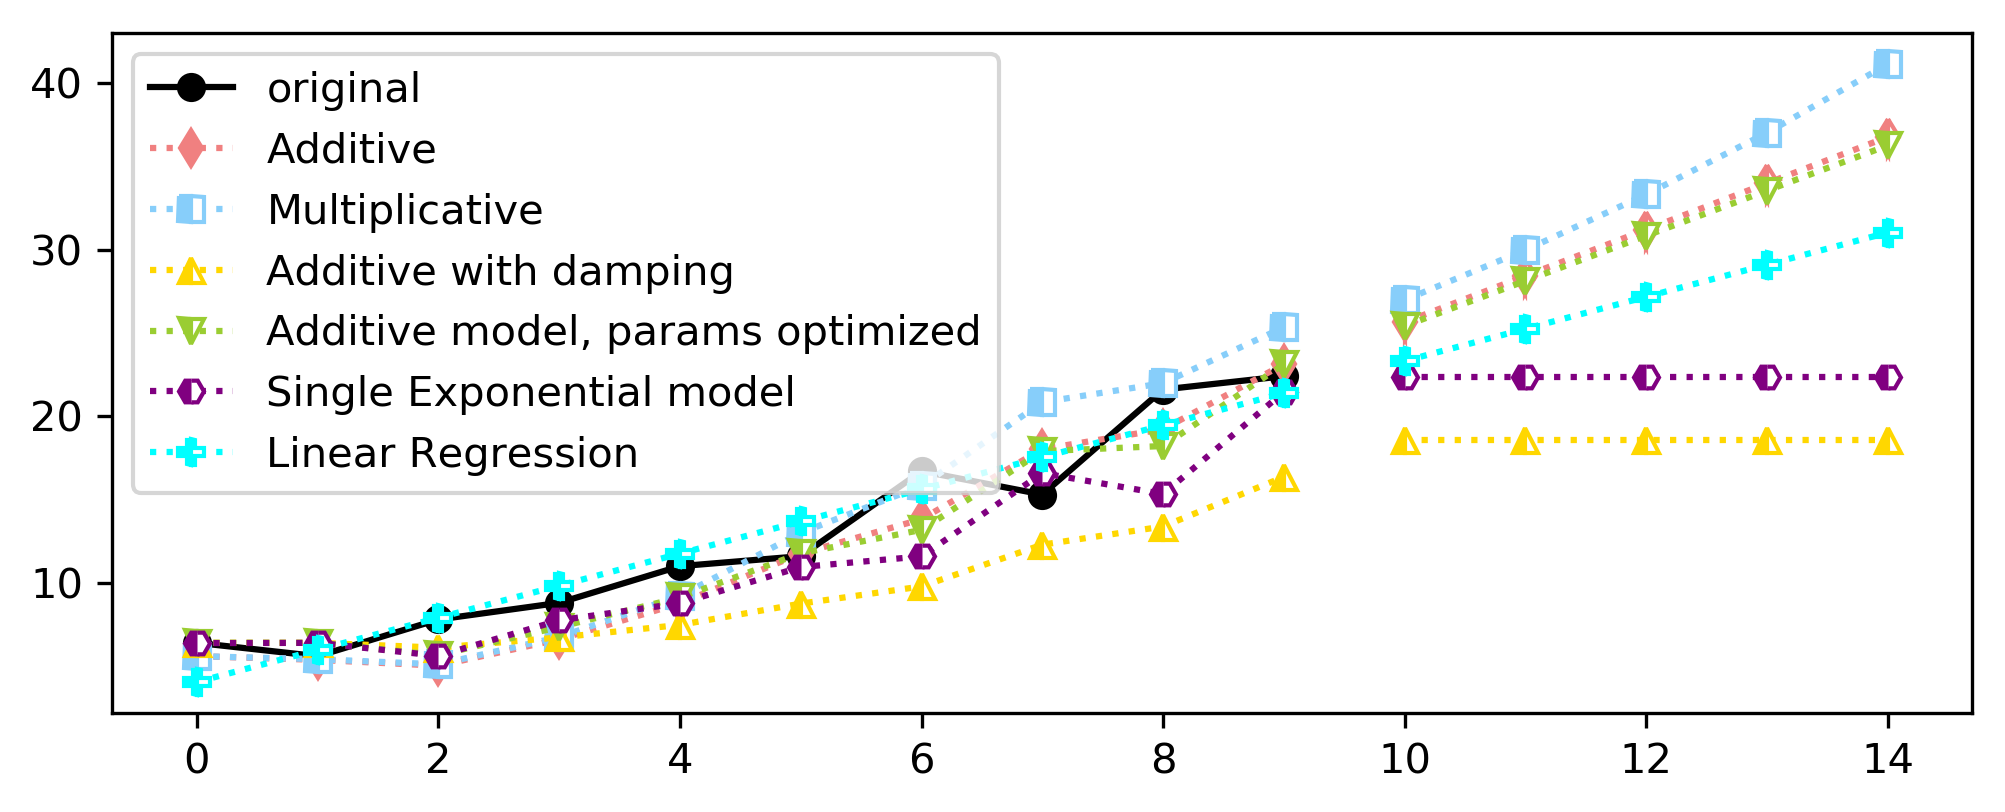

In [148]:
fig = plt.figure(figsize = (8, 3), dpi = 300)
plt.plot(range(len(dt)), dt, 'ko-', label='original')
plt.plot(range(len(dt)), fit1.fittedvalues, 'd:', color = 'lightcoral', label='Additive')
plt.plot(range(len(dt)), fit2.fittedvalues, 's:', color = 'lightskyblue', 
         label='Multiplicative', fillstyle = 'left', markerfacecoloralt = 'w')
plt.plot(range(len(dt)), fit3.fittedvalues, '^:', color = 'gold', 
         label='Additive with damping', fillstyle = 'left', markerfacecoloralt = 'w')
plt.plot(range(len(dt)), fit4.fittedvalues, 'v:', color = 'yellowgreen', 
         label='Additive model, params optimized', fillstyle = 'left', markerfacecoloralt = 'w')
plt.plot(range(len(dt)), fit5.fittedvalues, 'H:', color = 'purple', 
         label='Single Exponential model', fillstyle = 'left', markerfacecoloralt = 'w')
plt.plot(range(len(dt)), fit6.fittedvalues, 'P:', color='cyan', label='Linear Regression',
        fillstyle='left', markerfacecoloralt='w')

plt.plot(range(len(dt), len(dt)+5), fit1.forecast(5), 'd:', color = 'lightcoral',
        fillstyle = 'left', markerfacecoloralt = 'w')
plt.plot(range(len(dt), len(dt)+5), fit2.forecast(5), 's:', color = 'lightskyblue',
        fillstyle = 'left', markerfacecoloralt = 'w')
plt.plot(range(len(dt), len(dt)+5), fit3.forecast(5), '^:', color = 'gold',
        fillstyle = 'left', markerfacecoloralt = 'w')
plt.plot(range(len(dt), len(dt)+5), fit4.forecast(5), 'v:', color = 'yellowgreen',
         fillstyle = 'left', markerfacecoloralt = 'w')
plt.plot(range(len(dt), len(dt)+5), fit5.forecast(5), 'H:', color = 'purple',
        fillstyle = 'left', markerfacecoloralt = 'w')
plt.plot(range(len(dt), len(dt)+5), fit6.predict(sm.add_constant(range(len(dt), len(dt)+5))), 
         'P:', color='cyan', fillstyle='left', markerfacecoloralt='w')
plt.legend()

As we can see from the plot above, linear regression is more conservative than exponential smoothing.

## Triple Exponential Smoothing (Holt's Winter Seasonal)

Data from [NIST](https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc436.htm)

In [164]:
tri = pd.read_csv('data/TriExp.dat', skiprows = list(range(23))+[24], sep = '\s+')

Test different models
1. Additive trend, additive seasonal of period and the use of Boxcox transformation
1. Additive trend, multiplicative seasonal fo period and the use of Boxcox transformation
1. Additive damped trend, additive seasonal of period and the use of Boxcox transformation
1. Additive damped trend, multiplicative seasonal of period and the use of Boxcox transformation

In [201]:
fit1 = ExponentialSmoothing(tri['Sales'], seasonal_periods=4, 
                            trend='add', seasonal='add').fit(use_boxcox=True)
fit2 = ExponentialSmoothing(tri['Sales'], seasonal_periods=4, 
                            trend='add', seasonal='mul').fit(use_boxcox=True)
fit3 = ExponentialSmoothing(tri['Sales'], seasonal_periods=4, damped=True,
                            trend='add', seasonal='add').fit(use_boxcox=True)
fit4 = ExponentialSmoothing(tri['Sales'], seasonal_periods=4, damped=True,
                            trend='add', seasonal='mul').fit(use_boxcox=True)

In [202]:
results=pd.DataFrame(index=[r"$\alpha$",r"$\beta$",r"$\phi$",r"$\gamma$",
                            r"$l_0$","$b_0$","SSE"])
params = ['smoothing_level', 'smoothing_slope', 'damping_slope', 
          'smoothing_seasonal', 'initial_level', 'initial_slope']
results["Additive"]       = [fit1.params[p] for p in params] + [fit1.sse]
results["Multiplicative"] = [fit2.params[p] for p in params] + [fit2.sse]
results["Additive Dam"]   = [fit3.params[p] for p in params] + [fit3.sse]
results["Multiplica Dam"] = [fit4.params[p] for p in params] + [fit4.sse]

results

,Additive,Multiplicative,Additive Dam,Multiplica Dam
$\alpha$,8.707769e-01,8.026317e-01,8.708083e-01,8.026574e-01
$\beta$,1.879176e-09,1.455141e-15,3.734686e-09,1.964752e-16
$\phi$,NaN,NaN,9.999997e-01,1.000000e+00
$\gamma$,1.889048e-08,0.000000e+00,1.871305e-08,0.000000e+00
$l_0$,1.011395e+01,1.019780e+01,1.011401e+01,1.019777e+01
$b_0$,7.744059e-02,8.529658e-02,7.743612e-02,8.527289e-02
SSE,9.840756e+03,9.196425e+03,9.840637e+03,9.196030e+03


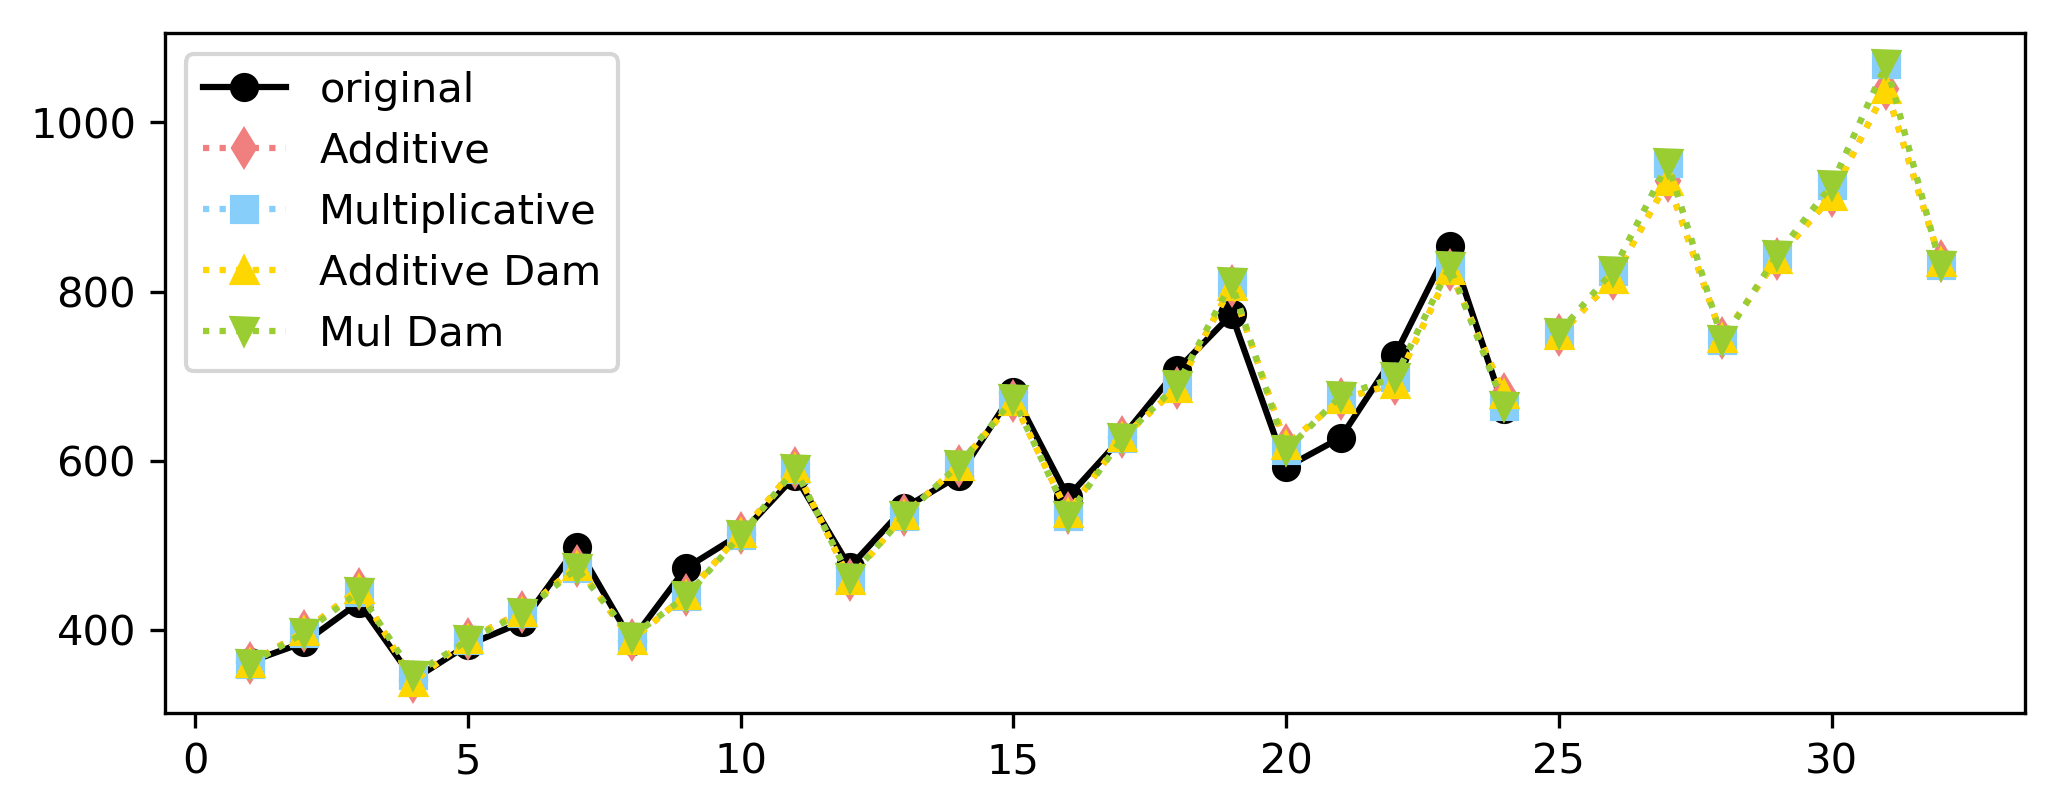

In [203]:
fig = plt.figure(figsize = (8, 3), dpi = 300)
plt.plot(tri['Period'], tri['Sales'], 'ko-', label='original')
plt.plot(tri['Period'], fit1.fittedvalues, 'd:', color = 'lightcoral', label='Additive')
plt.plot(tri['Period'], fit2.fittedvalues, 's:', color = 'lightskyblue', label='Multiplicative')
plt.plot(tri['Period'], fit3.fittedvalues, '^:', color = 'gold', label='Additive Dam')
plt.plot(tri['Period'], fit4.fittedvalues, 'v:', color = 'yellowgreen', label='Mul Dam')

temp = np.arange(tri['Period'].iloc[-1]+1, tri['Period'].iloc[-1]+9)
plt.plot(temp, fit1.forecast(8), 'd:', color = 'lightcoral')
plt.plot(temp, fit2.forecast(8), 's:', color = 'lightskyblue')
plt.plot(temp, fit3.forecast(8), '^:', color = 'gold')
plt.plot(temp, fit4.forecast(8), 'v:', color = 'yellowgreen')
plt.legend();

Does not show great difference.